Term Project

Team: Rain Price, Weston Scott

ECE 523 | Engineering Applications of Machine Learning and Data Analytics

Professor Abhijit Mahalanobis

# Vehicle and People Detection with the FLIR Thermal Dataset

![alt text](problemStatement.png)

## CURRENT

Currently only implemented stuff from the resource below

https://towardsdatascience.com/bounding-box-pred

The data for this is found here:

https://www.kaggle.com/datasets/andrewmvd/road-sign-detection

Put the data in a folder at the same level as this notebook titled test, then it should work

## TODO

- Get our dataset loaded and working
- Rewrite Resnet layers to be our own homegrown solution
- Clean up this code to make it our own
- Survive this class ....

## Import Libraries

In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
from torch.autograd import Variable
from torchvision import transforms as T
from torchvision.transforms import ToTensor, transforms
import copy
import json

## Check to see if input images are the same size

In [2]:
path = 'data/images_thermal_val/data'

from PIL import Image
import os
import numpy as np

imgs = os.listdir(path)
sizes = []
for img in imgs:
    filename = os.path.join(path, img)
    image = Image.open(filename)
    sizes.append(image.size)
    
np.unique(sizes, return_counts=True)

(array([512, 640]), array([1144, 1144]))

## Random Seed, Device Architecture, and Hyperparameters

In [3]:
%matplotlib inline
randomSeed = 13579
np.random.seed(randomSeed)
torch.manual_seed(randomSeed)

print(f'PyTorch Version: {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch Device: {device}')

saveModel = True
loadModel = False
modelPath = './model.pt'
maxEpochs = 50
numWorkers = 2    
learnRate = 0.006 #2e-5
batchSize = 24
maxEpochs = 10
loadSavedModel = False

PyTorch Version: 2.2.0
PyTorch Device: cpu


/home/wscott/apps/anacona3_2023.09/envs/pytorchGPU/lib/python3.12/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987289929/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Load Training/ Testing Data

In [4]:
trainPath = './data/images_thermal_train'
valPath = './data/images_thermal_val'
testPath = './data/video_thermal_test'
dataDir = 'data'
jsonFile = 'coco.json'

jsonFiles = { 
              'train' : os.path.join(trainPath, jsonFile),
              'val' : os.path.join(valPath, jsonFile),
              'test' : os.path.join(testPath, jsonFile)
            }

imagePaths = { 
              'train' : trainPath,
              'val' : valPath,
              'test' : testPath
            }

for key, val in jsonFiles.items():
    if os.path.isfile(val):
        print(f'coco.json Exists: {key}, {val}')
    
for key, val in imagePaths.items():
    if os.path.isdir(val):
        print(f'Data Directory Exists: {key}, {val}')

coco.json Exists: train, ./data/images_thermal_train/coco.json
coco.json Exists: val, ./data/images_thermal_val/coco.json
coco.json Exists: test, ./data/video_thermal_test/coco.json
Data Directory Exists: train, ./data/images_thermal_train
Data Directory Exists: val, ./data/images_thermal_val
Data Directory Exists: test, ./data/video_thermal_test


In [6]:
class ThermalCocoDataset(Dataset):
    def __init__(self, json_file, image_dir, transform=None):
        self.json_file = json_file
        self.image_dir = image_dir
        self.transform = transform
        self._load_json()

    def _load_json(self):
        with open(self.json_file, 'r') as f:
            data = json.load(f)
        
        self.annotations = data['annotations']
        self.images = data['images']
    
    def _map_images_to_id(self, id):
        for entry in self.images:
            if entry['id'] == id:
                return entry['file_name']

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        image_file_name = self._map_images_to_id(image_id)
        image_file = os.path.join(self.image_dir, f"{image_file_name}")
        image = Image.open(image_file)

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        # Assuming annotation format: [x, y, width, height]
        bbox = annotation['bbox']
        label = annotation['category_id']

        return image, bbox, label

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize image
])

trainData = ThermalCocoDataset(jsonFiles['train'], imagePaths['train'], transform=transform)
valData = ThermalCocoDataset(jsonFiles['val'], imagePaths['val'], transform=transform)
testData = ThermalCocoDataset(jsonFiles['test'], imagePaths['test'], transform=transform)

trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
valLoader = DataLoader(valData, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
testLoader = DataLoader(testData, batch_size=batchSize, shuffle=False, num_workers=numWorkers)

## Sample Imagery From Training Data

### Original Images (Training)

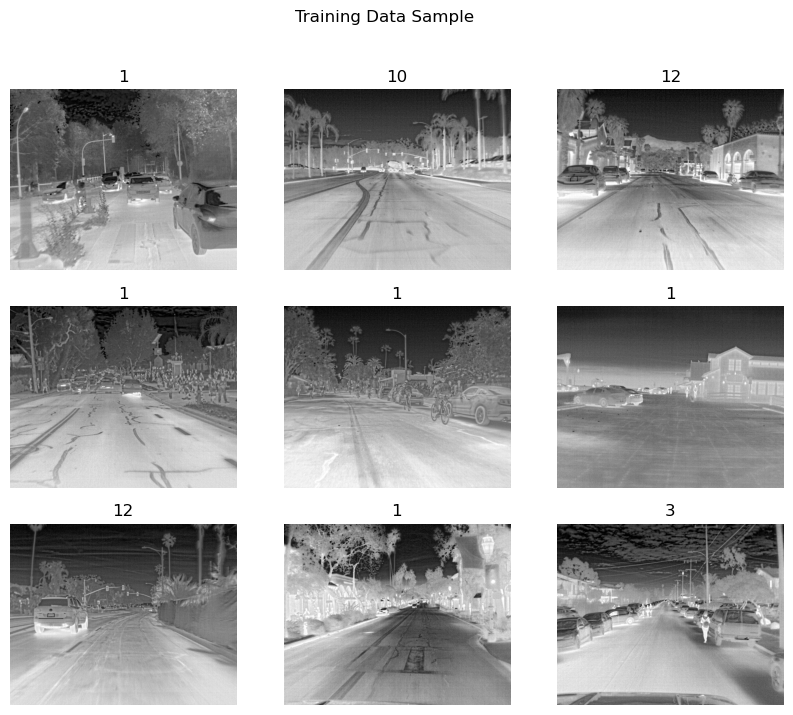

In [36]:
figure = plt.figure(figsize=(10, 8))
plt.suptitle('Training Data Sample')
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainData), size=(1,)).item()
    img, bbox, label = trainData[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Original Images (Validation)

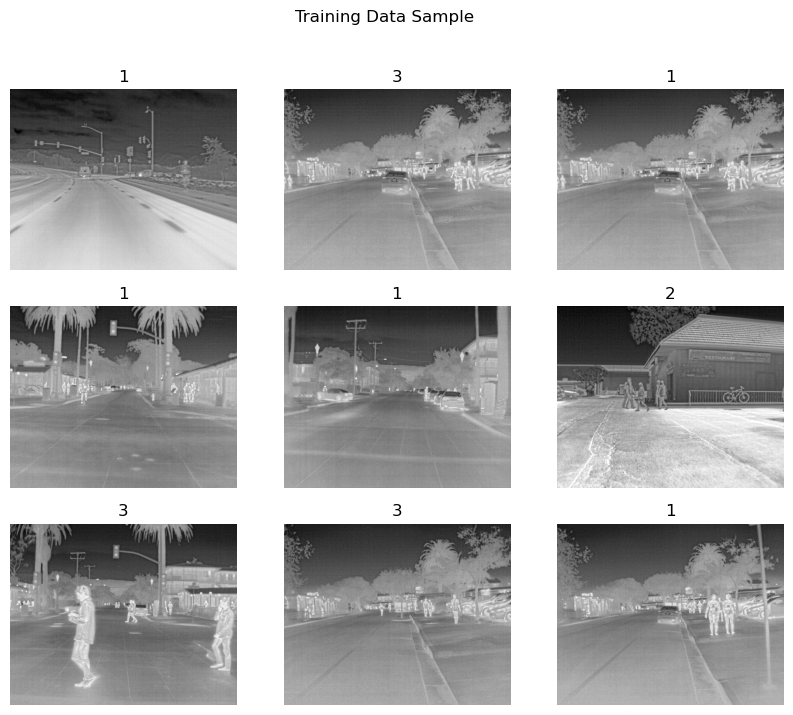

In [37]:
figure = plt.figure(figsize=(10, 8))
plt.suptitle('Training Data Sample')
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(valData), size=(1,)).item()
    img, bbox, label = trainData[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Original Images (Testing)

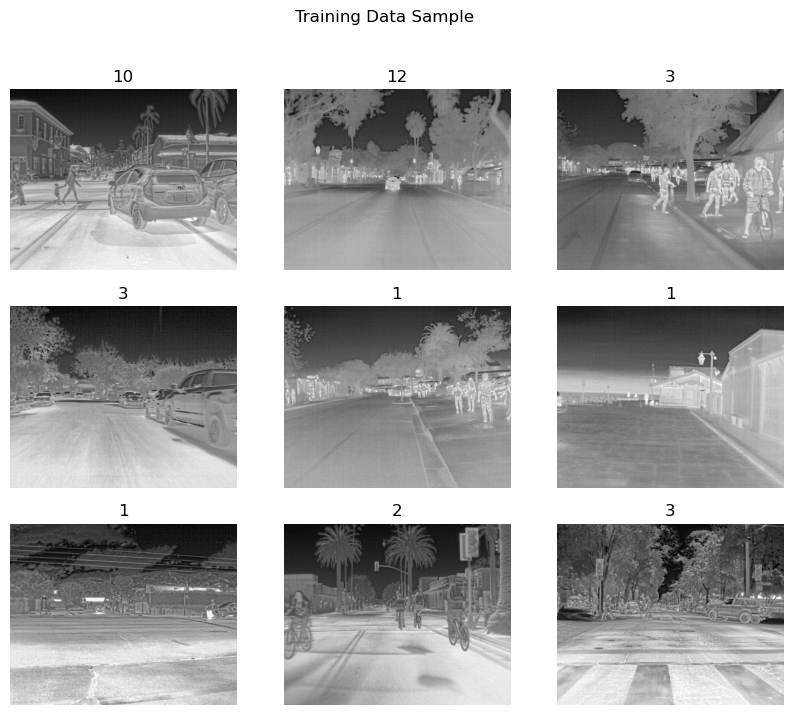

In [38]:
figure = plt.figure(figsize=(10, 8))
plt.suptitle('Training Data Sample')
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testData), size=(1,)).item()
    img, bbox, label = trainData[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## AutoEncoder Model Definition

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.relu = nn.ReLU()
        
        # Encoding
        self.batchNorm = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxPool2 = nn.MaxPool2d(kernel_size=3, stride=3, padding=1, return_indices=True)
        self.conv3 = nn.Conv2d(128, 16, kernel_size=3, stride=1, padding=1)
        
        # Decoding
        self.transposeConv1 = nn.ConvTranspose2d(16, 128, kernel_size=3, stride=1, padding=1)
        self.maxUnpool1 = nn.MaxUnpool2d(2, stride=3)
        self.transposeConv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.maxUnpool2 = nn.MaxUnpool2d(2, stride=2)
        self.transposeConv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        x, inds1, inds2 = self.encoder(x)
        activations = x.detach()
        x = self.decoder(x, inds1, inds2)
        return x, activations
    
    def encoder(self, xx):
        xx = self.batchNorm(xx)
        xx = self.conv1(xx)
        xx = self.relu(xx)
        xx, inds1 = self.maxPool1(xx)
        xx = self.conv2(xx)
        xx = self.relu(xx)
        xx, inds2 = self.maxPool2(xx)
        xx = self.conv3(xx)
        return xx, inds1, inds2
    
    def decoder(self, xx, inds1, inds2):
        xx = self.transposeConv1(xx)
        xx = self.relu(xx)
        xx = self.maxUnpool1(xx, inds2)
        xx = self.transposeConv2(xx)
        xx = self.relu(xx)
        xx = self.maxUnpool2(xx, inds1)
        xx = self.transposeConv3(xx)
        xx = self.conv4(xx)
        return xx
   
summary(AutoEncoder(), (1,28,28)) 

model = AutoEncoder()

## Set Criterion and Optimizer

In [ ]:
criterion = nn.MSELoss()   
print(f'Criterion: {criterion}')

optimizer = optim.Adam(model.parameters(), lr = learnRate)   
print(f'\nOptimizer: {optimizer}')

## Load Trained Model (If Needed)

In [ ]:
if loadModel:
    model = AutoEncoder()
    optimizer = optimizer
    checkpoint = torch.load(modelPath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']  

## Train Model

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

trainLoader = loaders['train']
testLoader = loaders['test']

if not loadModel:
     
    exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    train_loss_hist = []
    trainLoss = []
    activations0 = []

    for epoch in range(1, maxEpochs+1):
        epochLoss = []
        testEpochLoss = []
        model.train()

        for i, (images, labels, imagesFLipped) in enumerate(trainLoader):
            optimizer.zero_grad()
            images = images.to(device)
            outputs, acts = model(images)
            loss = criterion(outputs, imagesFLipped.to(device))
            loss.backward()          
            optimizer.step()
            lossVal = loss.item()
            epochLoss.append(float(lossVal))
            activations0.append(acts.detach().cpu().numpy())
                
        trainLoss.append(np.mean(epochLoss))
        exp_lr_scheduler.step(trainLoss[-1])
                
        print(f'[Epoch: {epoch}/{maxEpochs}] Loss: {np.round(trainLoss[-1], 5)}')

        if saveModel and epoch % 5 == 0: ## save model every 5th epoch
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': criterion,
                    }, modelPath)

## Save Model (If Needed)

In [ ]:
if saveModel and not loadModel:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, modelPath)

## Learning Curve

In [ ]:
if not loadModel:
    print(f'Final MSE ({maxEpochs} epochs): {trainLoss[-1]}\n')
    
    f = plt.figure(figsize=(10,8))
    plt.plot(trainLoss, label="train")
    plt.xlabel("epochs")
    plt.ylabel("cross entropy")
    plt.title("Epochs vs. Loss Function")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Sample Imagery of Model Output

### Training Images Samples

In [ ]:
trainImages, trainLabels, trainImagesFlipped = next(iter(trainLoader))
samples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

model.eval()
with torch.no_grad():
    outputs, __ = model(trainImages.to(device))

j = 0
for i, label in enumerate(trainLabels):
    if label.item() in samples:
        f = plt.figure(figsize=(12, 4))      
        ax1 = f.add_subplot(131)
        ax1.imshow(trainImages[i].squeeze(), cmap='gray')
        ax1.axis('off')
        ax1.set_title(f'Original - {label.item()}')
        ax2 = f.add_subplot(132)
        ax2.imshow(outputs[i].detach().cpu()[0].squeeze(), cmap='gray')
        ax2.axis('off')
        ax2.set_title(f'Reconstruction (Flipped) - {label.item()}')
        plt.tight_layout()
        plt.show()
        
        samples.remove(label.item())
        j += 1

### Test Images Samples

In [ ]:
testImages, testLabels, testImagesFlipped = next(iter(testLoader))
samples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

model.eval()
with torch.no_grad():
    outputs, __ = model(testImages.to(device))

j = 0
for i, label in enumerate(testLabels):
    if label.item() in samples:
        f = plt.figure(figsize=(12, 4))      
        ax1 = f.add_subplot(131)
        ax1.imshow(testImages[i].squeeze(), cmap='gray')
        ax1.axis('off')
        ax1.set_title(f'Original - {label.item()}')
        ax2 = f.add_subplot(132)
        ax2.imshow(outputs[i].detach().cpu()[0].squeeze(), cmap='gray')
        ax2.axis('off')
        ax2.set_title(f'Reconstruction (Flipped) - {label.item()}')
        plt.tight_layout()
        plt.show()
        
        samples.remove(label.item())
        j += 1

## Check Individual Digit MSE

In [ ]:
def digitMSE(model, criterion, images, labels, flippedImages):
    
    model.eval()
    with torch.no_grad():
        mse = []
        for i, image in enumerate(images):
            outputs, __ = model(image.reshape((1,1,28,28)).to(device))
            mse.append(criterion(outputs, flippedImages[i].reshape((1,1,28,28)).to(device)))

    mse_per_digit = {}
    count_per_digit = {}

    for i, label in enumerate(labels):
        mse_i = mse[i].sum().item()
        if mse_per_digit.get(label.item(), 0) == 0:
            mse_per_digit[label.item()] = mse_i
            count_per_digit[label.item()] = 1
        else:
            mse_per_digit[label.item()] += mse_i
            count_per_digit[label.item()] += 1
            
    for digit, mse_sum in mse_per_digit.items():
        count_i = count_per_digit[digit]
        mse_per_digit[digit] = mse_sum / count_i
    
    return mse_per_digit

### Training Digit MSE

In [ ]:
mseDigitTrain = digitMSE(model, criterion, trainImages, trainLabels, trainImagesFlipped)
for digit, mse in mseDigitTrain.items():
    print(f'Digit {digit} MSE: {mse}')
    
minMSETrain = min(mseDigitTrain, key=mseDigitTrain.get)
print(f'\nDigit with Lowest MSE: {minMSETrain} | {mseDigitTrain[minMSETrain]}')

### Testing Digit MSE

In [ ]:
mseDigitsTest = digitMSE(model, criterion, testImages, testLabels, testImagesFlipped)
for digit, mse in mseDigitsTest.items():
    print(f'Digit {digit} MSE: {mse}')
    
minMSETest = min(mseDigitTrain, key=mseDigitTrain.get)
print(f'\nDigit with Lowest MSE: {minMSETest} | {mseDigitTrain[minMSETest]}')

The digits do not all have the same MSE, suggesting that some shapes are easier than others to approximate. Obviously with 1 being a line (in most cases) it would be the easiest to achieve the lowest MSE for a flipped image, and the data supports that. Other digits however are more complex, with circles or even non-uniform curves due to the nature of this dataset being handwriting

## Activation Histograms of Embedded Space

In [ ]:
# Concatenate and reshape activations
activations = np.concatenate(activations0, axis=0)
activations = activations.reshape(-1, 16, 5, 5)  # Reshape to (num_samples, 16, 5, 5)
activations_flattened = activations.reshape(activations.shape[0], -1)  # Flatten each image

In [ ]:
# Plot histograms of the first five features
for feature_idx in range(5):
    plt.figure(figsize=(8, 6))
    plt.hist(activations_flattened[:, feature_idx], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of Feature {feature_idx + 1}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## Mean, Variance, and Covariance

In [ ]:
# Plot histograms of the first five features
means = []
variances = []
covariances = []
for feature_idx in range(5):
    means.append(np.mean(activations_flattened[:, feature_idx]))
    variances.append(np.var(activations_flattened[:, feature_idx]))
    covariances.append(np.cov(activations_flattened[:, feature_idx]))
    print(f'Feature {feature_idx+1} Mean: {means[-1]}')
    print(f'Feature {feature_idx+1} Variance: {variances[-1]}')
    print(f'Feature {feature_idx+1} Covariance: {covariances[-1]}\n')
    
# Calculate the covariance matrix
cov_matrix = np.cov(activations_flattened[:, :5].T)
print(f"\nCovariance Matrix:\n{cov_matrix}")

### Comparison Histograms

In [ ]:
# Generate a set of five-dimensional Gaussian random vectors using the calculated mean and covariance
generated_data = np.random.multivariate_normal(means, cov_matrix, size=activations_flattened.shape[0])

# Plot histograms of the generated data and compare with the original histograms
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.hist(activations_flattened[:, i], bins=20, color='red', alpha=0.6, label='Original')
    plt.hist(generated_data[:, i], bins=20, color='blue', alpha=0.3, label='Generated')
    plt.title(f'Feature {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

### Discussion

The histograms from the activations are all gaussian. Which makes sense for several reasons. One being that we are following a gaussian-based loss function (MSE Loss), another is that the data's underlying patterns follow gaussian distributions. The results demonstrate that the model is effectively capturing the statistical properties of the training and testing data. The comparison histograms also match fairly well , with the means centered similarly and the variance spreading similarly as well.